In [1]:
import math
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -  4*x + 5

In [3]:
f(3.0)

20.0

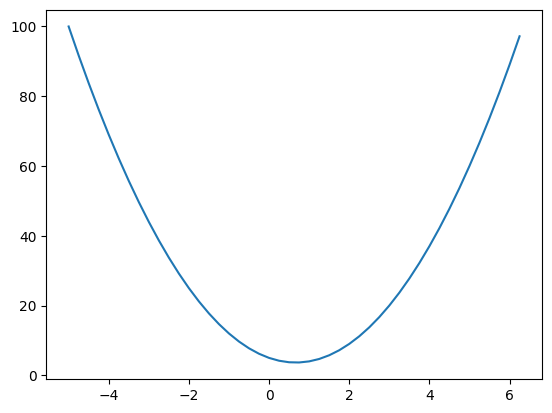

In [4]:
xs=np.arange(-5, 6.26, 0.25)
ys=f(xs)    
plt.plot(xs, ys)

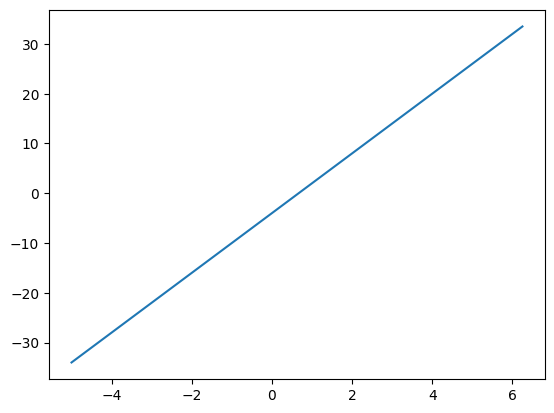

In [5]:
def derf(x):     # derivative of f(x)
    return 6*x - 4

xs=np.arange(-5, 6.26, 0.25)
ys=derf(xs)
plt.plot(xs, ys)

In [6]:
h = 0.0000001
x = -3.0
derivative = (f(x+h) - f(x))/h
print(derivative)

-21.999999688659955


In [7]:
# lets get more complex

a=2.0
b=-3.0
c=10.0  
d=a*b + c
print(d)

4.0


In [8]:
h = 0.0001

# Inputs
a=2.0
b=-3.0
c=10.0  


d1=a*b + c
a+=h
d2=a*b + c

print('d1 -->', d1) 
print('d2 -->', d2)
print('slope -->', (d2-d1)/h)

d1 --> 4.0
d2 --> 3.999699999999999
slope --> -3.000000000010772


d2 decreased => slope is negative

In [33]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad=0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    

a=Value(2.0, label='a')
b=Value(-3.0, label='b')
c=Value(10.0, label='c')
e=a+b; e.label='e'
d=e+c; d.label='d'
f=Value(3.0, label='f')
L=d*f; L.label='L'
L

Value(data=27.0)

In [34]:
from graphviz import Digraph # type: ignore

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [37]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})   # Left to Right
    nodes, edges = trace(root)
    for n in nodes:
        uid= str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

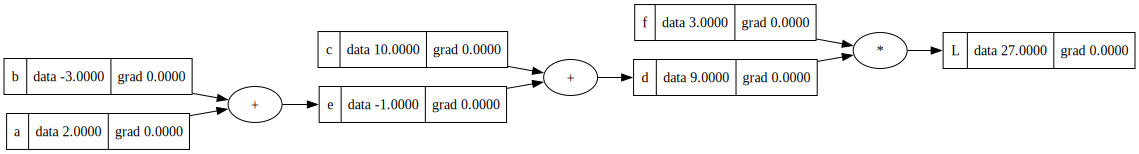

In [38]:
draw_dot(L)

In [40]:
def lol():
    h=0.0001
    a=Value(2.0, label='a')
    b=Value(-3.0, label='b')
    c=Value(10.0, label='c')
    e=a+b; e.label='e'
    d=e+c; d.label='d'
    f=Value(3.0, label='f')
    L=d*f; L.label='L'
    L1=L.data

    a=Value(2.0 + h, label='a')
    b=Value(-3.0, label='b')
    c=Value(10.0, label='c')
    e=a+b; e.label='e'
    d=e+c; d.label='d'
    f=Value(3.0, label='f')
    L=d*f; L.label='L'
    L2=L.data
    print('slope -->', (L2.data-L1.data)/h)
    
lol()

AttributeError: 'float' object has no attribute 'data'